# Assignment 4

In [1]:
import sklearn 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import feature as ft

## 1 - Dataset Overview

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
testbatch = './cifar-10-batches-py/test_batch'
testbatch_raw = unpickle(testbatch)

#reshape the serialized array
image_test = testbatch_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 

print(testbatch_raw[b'data'].shape)




(10000, 3072)


In [5]:
data_path = './cifar-10-batches-py/data_batch_1'
category_path = './cifar-10-batches-py/batches.meta'

batch_raw = unpickle(data_path)
categ = unpickle(category_path)
print(categ)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


airplane


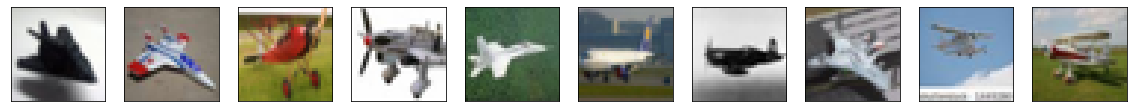

automobile


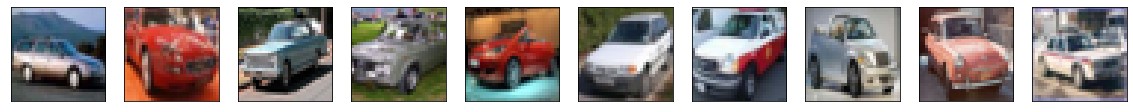

bird


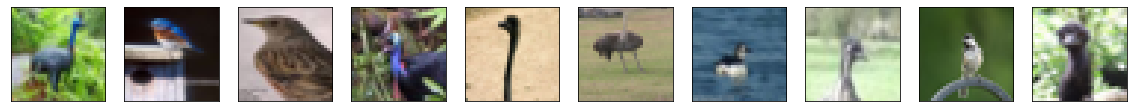

cat


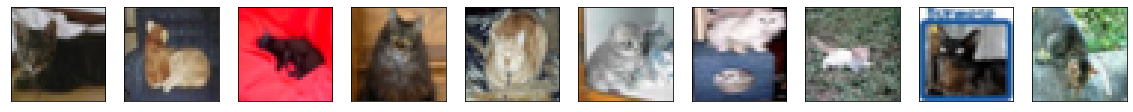

deer


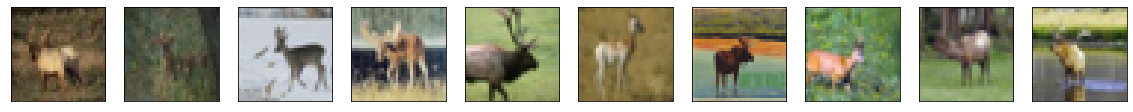

dog


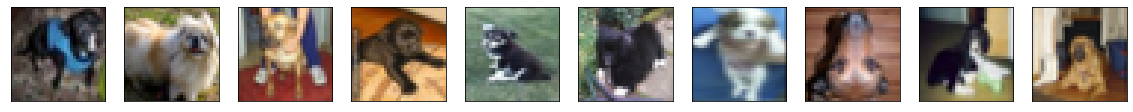

frog


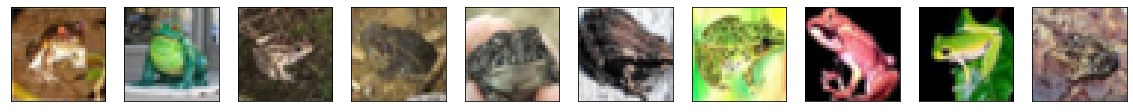

horse


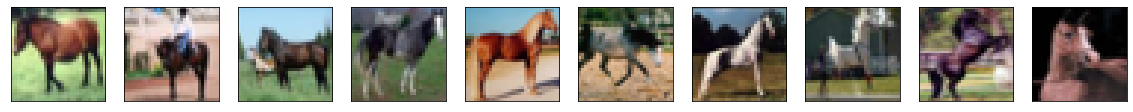

ship


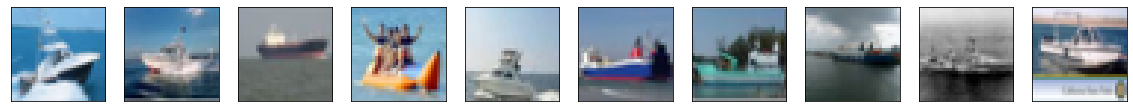

truck


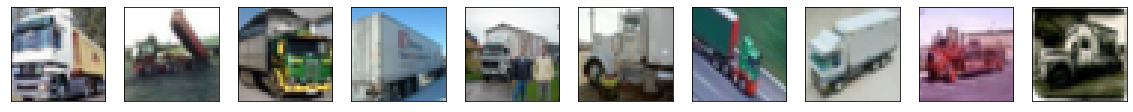

In [55]:
#reshape the serialized array
image_batch_1 = batch_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 

for i in range(10):
    counter = 0 #count number of images in each category
    j = 0 #iterate through 10000 images
    print(categ[b'label_names'][i].decode('utf-8'))
    plt.figure(figsize = (20,5))
    while(counter < 10):
        if(batch_raw[b'labels'][j] == i):
            plt.subplot(1,10,counter+1), plt.imshow(image_batch_1[j])
            plt.xticks([]), plt.yticks([])
            counter += 1
        j += 1
    plt.show()
    
    #use hashtable

## Feature extraction

### Mean Intensity

In [56]:
def mean_intensity(data):
    """ Input: raw pickle data, (10000,3072)
        Output: array of mean of each channel of each image, (10000,3)"""
    
    mean_features = [] # outputed array
    for i in range(10000):
            mean_intensity = []
            mean_intensity.append(np.mean(data[i][0:1024])) # mean red pixels
            mean_intensity.append(np.mean(data[i][1024:2048])) # mean green pixels
            mean_intensity.append(np.mean(data[i][2048:3072])) # mean blue pixels
            mean_features.append(mean_intensity)

    return np.asarray(mean_features)  

## HOG

In [57]:
def func_HOG(img_list, cell_size=(8,8), block_size=(2,2), nbins=9):

    #list of hog features
    hog_feats = [None] * len(img_list)
    
    for i in range(len(img_list)):
        img = cv2.cvtColor(img_list[i], cv2.COLOR_RGB2GRAY)
        hog_feats[i] = ft.hog(img, orientations = nbins, pixels_per_cell = cell_size,
               cells_per_block = block_size, block_norm='L2-Hys')
    
    return (hog_feats)

## 2 - SVMs

### 2.1 - Linear SVMs - Exploring features

In [58]:
# create linear SVM estimator instance
clf_linear = svm.SVC(gamma='scale', kernel='linear') 

#labels of train batch #1
labels = batch_raw[b'labels']

### Mean shift

In [59]:
mean_ft_train = mean_intensity(batch_raw[b'data'])
clf_linear.fit(mean_ft_train, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
mean_ft_test = mean_intensity(testbatch_raw[b'data']) 

test_labels_ms = clf_linear.predict(mean_ft_test)

### Evaluation Metrics

Accuracy of linear SVM using mean shift features: 24.05%

Confusion Matrix


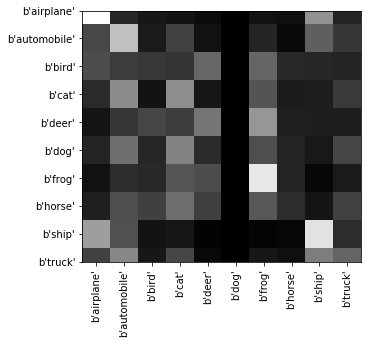

In [61]:
# Accuracy
print("Accuracy of linear SVM using mean shift features: " + str(100*accuracy_score(test_labels_ms, testbatch_raw[b'labels'] )) + "%")

#Confusion matrix
print('\nConfusion Matrix')
# Create the confusion matrix using the function:
conf_mean_linear = confusion_matrix(testbatch_raw[b'labels'], test_labels_ms ) # (answers, predictions)

plt.figure(figsize = (5,10))
plt.imshow(conf_mean_linear, cmap='gray') 
plt.xticks(np.arange(10),categ[b'label_names'], rotation = 90)
plt.yticks(np.arange(10),categ[b'label_names'])
plt.show()

### HOG

In [62]:
hog_ft_train = func_HOG(image_batch_1)

In [63]:
clf_linear.fit(hog_ft_train,labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
hog_ft_test = func_HOG(image_test)

In [65]:
test_labels_hog_linear = clf_linear.predict(hog_ft_test)

### Evaluation Metrics

Accuracy of linear SVM using HOG features: 49.24%

Confusion Matrix


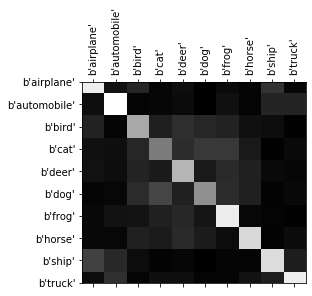

In [66]:
# Accuracy 
print("Accuracy of linear SVM using HOG features: " + str(100*accuracy_score(test_labels_hog_linear, testbatch_raw[b'labels'] )) + "%")

# Confusion matrix
print('\nConfusion Matrix')
# Create the confusion matrix using the function:
conf_hog_linear = confusion_matrix(testbatch_raw[b'labels'], test_labels_hog_linear ) # (answers, predictions)

# We can plot images using pyplot.imshow( ???)
# plt.figure()
# plt.matshow(conf_hog_linear, cmap='gray')
# plt.show()
# plt.figure(figsize = (10,10))
plt.matshow(conf_hog_linear, cmap='gray') 
plt.xticks(np.arange(10),categ[b'label_names'], rotation = 90)
plt.yticks(np.arange(10),categ[b'label_names'])
plt.show()

The accuracy using HOG features is higher than the accuracy using mean intensity (49% vs 9%) HOG features gives better result than mean intensity values. By comparing both confusion matrix, it is clear that the hog features performed better since the diagonal line (correct predictions) has a higher intensity than the rest of the matrix (wrong predictions).

It is expected because mean intensity computes the means of each channel in the picture and does not take shapes into account, i.e. an image of a  blue car and an image of a blue truck will have approximately the same mean intensity. On the other hand, HOG features takes shapes into account this is why it gives better result. 

Both feature extraction method could work well in recognizing a specific animal that has the same color most of the time, i.e. the frog. By analyzing the confusion matrix when using mean intensity features, the frog object is one of the object that has the most correct predictions because almost all frogs are green. In addition, by analyzing the confusing matrix when using hog features, the frog object has the most correct predictions (bright square on diagonal line). 

### 2.2 - Non-Linear SVMs - Exploring SVM kernels

### Kernel = Poly

In [67]:
# create SVM estimator instance
clf_poly = svm.SVC(gamma='scale', kernel = 'poly') 

clf_poly.fit(hog_ft_train, labels)
test_labels_poly = clf_poly.predict(hog_ft_test)


### Evaluation Metrics

In [68]:
# Accuracy 
print("Accuracy of Non-linar SVM using poly kernel: " + str(100*accuracy_score(test_labels_poly, testbatch_raw[b'labels'] )) + "%")

Accuracy of Non-linar SVM using poly kernel: 54.86%


### Kernel = rbf

In [69]:
# create SVM estimator instance
clf_rbf = svm.SVC(gamma='scale', kernel = 'rbf') 

clf_rbf.fit(hog_ft_train, labels)
test_labels_rbf = clf_rbf.predict(hog_ft_test)


### Evaluation metrics

In [70]:
# Accuracy 
print("Accuracy of Non-linar SVM using rbf kernel: " + str(100*accuracy_score(test_labels_rbf, testbatch_raw[b'labels'] )) + "%")

Accuracy of Non-linar SVM using rbf kernel: 56.18%


The accuracy of the SVM with a polynomial (54.86%) or a radial basis function (56.18%) kernel give better accuracy than SVM with a linear kernel (49.24%). 
The data that is classified is not linearly seprable 

## 3 - Random Forest Classifiers

### 3.1 RF - Exploring Performance of HoG Features

In [71]:
# create random forest classifier
clf_rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')

# fit and predict
clf_rf.fit(hog_ft_train, labels)
test_labels_rf = clf_rf.predict(hog_ft_test)

# Accuracy 
print("Accuracy of random forest classifiers: " + str(100*accuracy_score(test_labels_rf, testbatch_raw[b'labels'] )) + "%")


Accuracy of random forest classifiers: 45.14%


### 3.2 RF - Exploring Different Number of Trees (estimators)

Accuracy of random forest classifiers with n_estimators = 40 : 40.77%
Accuracy of random forest classifiers with n_estimators = 200 : 47.870000000000005%
Accuracy of random forest classifiers with n_estimators = 250 : 48.84%


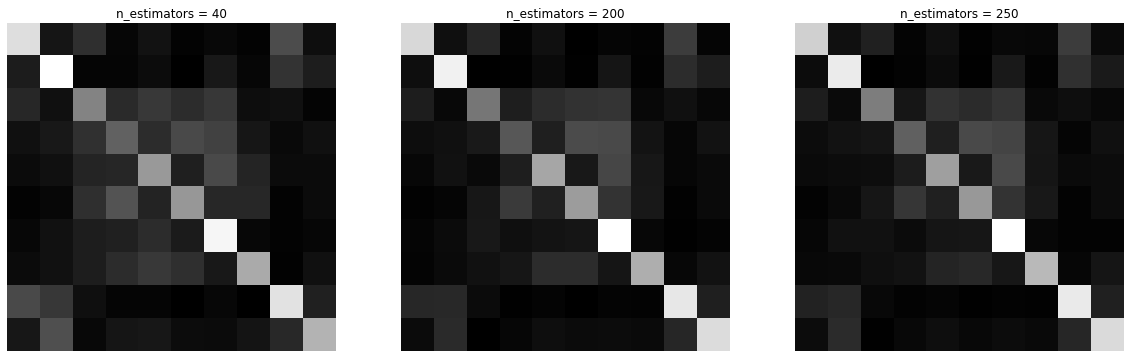

In [72]:
n_array = [40,200,250]
test_labels_rf = []
# loop to test different values of n_estimators, each loop will display the evaluation metrics 
plt.figure(figsize = (20,10))
for i in range(len(n_array)):
    
    # create random forest classifier
    clf_rf = RandomForestClassifier(n_estimators = n_array[i], criterion = 'entropy')
    
    # fit and predict
    clf_rf.fit(hog_ft_train, labels)
    test_labels_rf = clf_rf.predict(hog_ft_test)
    print("Accuracy of random forest classifiers with n_estimators = {0} : {1}%".format(n_array[i],100*accuracy_score(test_labels_rf, testbatch_raw[b'labels'])))
    
    # Confusion matrix
    # Create the confusion matrix using the function:
    conf = confusion_matrix(testbatch_raw[b'labels'], test_labels_rf ) # (answers, predictions)
#     print(conf)
    plt.subplot(1,3,i+1), plt.title("n_estimators = " + str(n_array[i]))
    plt.axis('off'), plt.imshow(conf, cmap='gray')

plt.show()
    


    
    

The accuracy increases when the number of trees increases. n_estimators = 250 gives the best result.

## 4 - Comparison of Classifiers

### 4.1 Performance Analysis

Best performing random forest classifier, n_estimators = 250
Accuracy of rf on training set : 100.0%
Accuracy of rf on testing set : 47.79%


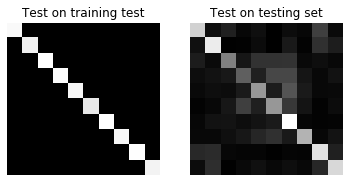


Best performing SVM kernel is rbf
Accuracy of SVM on training set : 81.15%
Accuracy of SVM on testing set : 56.18%


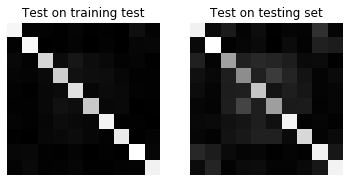

In [73]:
print("Best performing random forest classifier, n_estimators = 250")
clf_rf_250 = RandomForestClassifier(n_estimators = 250, criterion = 'entropy' )
clf_rf_250.fit(hog_ft_train, labels)

#use training set as testing set 
train_labels_rf = clf_rf_250.predict(hog_ft_train)

#use testing set as testing set 
test_labels_rf = clf_rf_250.predict(hog_ft_test)

print("Accuracy of rf on training set : {0}%".format(100*accuracy_score(train_labels_rf, batch_raw[b'labels'])))
print("Accuracy of rf on testing set : {0}%".format(100*accuracy_score(test_labels_rf, testbatch_raw[b'labels'])))

# Confusion matrix
# Create the confusion matrix using the function:
conf = confusion_matrix(batch_raw[b'labels'], train_labels_rf ) # (answers, predictions)
plt.subplot(1,2,1), plt.title("Test on training test")
plt.axis('off'), plt.imshow(conf, cmap='gray')

conf = confusion_matrix(testbatch_raw[b'labels'], test_labels_rf ) # (answers, predictions)
plt.subplot(1,2,2), plt.title("Test on testing set")
plt.axis('off'), plt.imshow(conf, cmap='gray')
plt.show()



print("\nBest performing SVM kernel is rbf")
#use training set as testing set 
train_labels_rbf = clf_rbf.predict(hog_ft_train)

#use testing set as testing set 
test_labels_rbf = clf_rbf.predict(hog_ft_test)

print("Accuracy of SVM on training set : {0}%".format(100*accuracy_score(train_labels_rbf, batch_raw[b'labels'])))
print("Accuracy of SVM on testing set : {0}%".format(100*accuracy_score(test_labels_rbf, testbatch_raw[b'labels'])))

# Confusion matrix
# Create the confusion matrix using the function:
conf = confusion_matrix(batch_raw[b'labels'], train_labels_rbf ) # (answers, predictions)
plt.subplot(1,2,1), plt.title("Test on training test")
plt.axis('off'), plt.imshow(conf, cmap='gray')

conf = confusion_matrix(testbatch_raw[b'labels'], test_labels_rbf ) # (answers, predictions)
plt.subplot(1,2,2), plt.title("Test on testing set")
plt.axis('off'), plt.imshow(conf, cmap='gray')
plt.show()



Based on the previous sections results, when the model is trained and tested on two different datasets, the best SVM classifier looks to be better than the best random forest classifier (56.18% VS 48.53% accuracy). 

When the model is trained and tested on the same dataset, the accuracy is much higher than when the model is trained and tested on two different datasets. In fact, the random forest classifier is 100% accurate and the SVM classifier is 81% accurate.


### 4.2 Exploring Different Parameters of HoG

In [74]:
cell_size = [[4,4],[8,8]]
block_size = [[2,2],[4,4]]
n_bins = [5,9,15]
best_accuracy = 0
best_params = {
  "cellSize": (0,0),
  "blockSize": (0,0),
  "nBins": 0,
    "score": 0
}

In [75]:
print("1st experiment: Modify cell_size and fix other parameters")
for i in range(len(cell_size)):
    hog_ft_train = func_HOG(image_batch_1, cell_size = cell_size[i])
    clf_rbf.fit(hog_ft_train, labels)
    hog_ft_test = func_HOG(image_test, cell_size = cell_size[i])
    test_labels_rbf = clf_rbf.predict(hog_ft_test)
    score = 100*accuracy_score(test_labels_rbf, testbatch_raw[b'labels'])
    print("Accuracy with cell_size = {0} : {1}%".format(cell_size[i],score))
        # if actual score is better than best accuracy, update best_params

    if ( score > best_accuracy ):
        best_accuracy = score
        best_params["cellSize"] = cell_size[i]
        best_params["blockSize"] = (8,8) #default value
        best_params["nBins"] = 9 #default value
        best_params["score"] = score

    

1st experiment: Modify cell_size and fix other parameters
Accuracy with cell_size = [4, 4] : 53.49%
Accuracy with cell_size = [8, 8] : 56.18%


In [76]:
print("2nd experiment: Modify block_size and fix other parameters")
for i in range(len(block_size)):
    hog_ft_train = func_HOG(image_batch_1, block_size = block_size[i])
    clf_rbf.fit(hog_ft_train, labels)
    hog_ft_test = func_HOG(image_test, block_size = block_size[i])
    test_labels_rbf = clf_rbf.predict(hog_ft_test)
    score = 100*accuracy_score(test_labels_rbf, testbatch_raw[b'labels'])
    print("Accuracy with block_size = {0} : {1}%".format(block_size[i], score))
    # if actual score is better than best accuracy, update best_params
    if ( score > best_accuracy ): 
        best_accuracy = score
        best_params["cellSize"] = (8,8) #default value
        best_params["blockSize"] = block_size[i]
        best_params["nBins"] = 9 #default value
        best_params["score"] = score

2nd experiment: Modify block_size and fix other parameters
Accuracy with block_size = [2, 2] : 56.18%
Accuracy with block_size = [4, 4] : 57.17%


In [77]:
print("3rd experiment: Modify n_bins and fix other parameters")
for i in range(len(n_bins)):
    hog_ft_train = func_HOG(image_batch_1,nbins = n_bins[i])
    clf_rbf.fit(hog_ft_train, labels)
    hog_ft_test = func_HOG(image_test, nbins = n_bins[i])
    test_labels_rbf = clf_rbf.predict(hog_ft_test)
    score = 100*accuracy_score(test_labels_rbf, testbatch_raw[b'labels'])
    print("Accuracy with n_bins = {0} : {1}%".format(n_bins[i], score))
    # if actual score is better than best accuracy, update best_params
    if ( score > best_accuracy ): 
        best_accuracy = score
        best_params["cellSize"] = (8,8) #default value
        best_params["blockSize"] = (2,2) #default value
        best_params["nBins"] = n_bins[i] 
        best_params["score"] = score

3rd experiment: Modify n_bins and fix other parameters
Accuracy with n_bins = 5 : 54.339999999999996%
Accuracy with n_bins = 9 : 56.18%
Accuracy with n_bins = 15 : 55.96%


In [78]:
print("Best performing HOG parameters:")
for key,val in best_params.items():
    print(key, ": ", val)

Best performing HOG parameters:
cellSize :  (8, 8)
blockSize :  [4, 4]
nBins :  9
score :  57.17


In each experiment, I modify one of the HOG parameters and fix the two others. To find the best parameters, I compare the accuracy of each experiment and save the parameters of the experience get the highest accuracy. 

### 4.3 Folded Validation

In [79]:
data_path = './cifar-10-batches-py/data_batch_2'
batch_raw_2 = unpickle(data_path)
image_batch_2 = batch_raw_2[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 

data_path = './cifar-10-batches-py/data_batch_3'
batch_raw_3 = unpickle(data_path)
image_batch_3 = batch_raw_3[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 


data_path = './cifar-10-batches-py/data_batch_4'
batch_raw_4 = unpickle(data_path)
image_batch_4 = batch_raw_4[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 


image_train  = [image_batch_2, image_batch_3, image_batch_4]
batch_labels = [batch_raw_2[b'labels'], batch_raw_3[b'labels'], batch_raw_4[b'labels']]

# extract hog features of testing set
hog_ft_test = func_HOG(image_test, block_size = (4,4)) # best parameters found in section 4.2

In [80]:
# best performing svm classifier kernel is rbf 
for i in range(len(image_train)):
    hog_ft_train = func_HOG(image_train[i], block_size = (4,4)) # best parameters found in section 4.2
    
    # SVM classifier
    clf_rbf.fit(hog_ft_train, batch_labels[i])

    # test model
    test_labels_rbf = clf_rbf.predict(hog_ft_test)
    
    # Accuracy
    score_svm = 100*accuracy_score(test_labels_rbf, testbatch_raw[b'labels'])
    print("SVM, Accuracy with test batch #{0} : {1}%".format(i+2, score_svm))

SVM, Accuracy with test batch #2 : 55.94%
SVM, Accuracy with test batch #3 : 56.16%
SVM, Accuracy with test batch #4 : 56.13%


In [81]:

for i in range(len(image_train)):
    hog_ft_train = func_HOG(image_train[i], block_size = (4,4)) # best parameters found in section 4.2
    
    # random forest classifier
    clf_rf_250.fit(hog_ft_train, batch_labels[i])
    
    # test model
    test_labels_rf = clf_rf_250.predict(hog_ft_test)
    
    # Accuracy
    score_rf = 100*accuracy_score(test_labels_rf, testbatch_raw[b'labels'])
    print("RF, Accuracy with test batch #{0} : {1}%".format(i+2, score_rf))

RF, Accuracy with test batch #2 : 47.71%
RF, Accuracy with test batch #3 : 48.14%
RF, Accuracy with test batch #4 : 47.8%


The model is trained with different batches and tested with the same testing batch. The accuracy does not vary a lot between the experiments. 

### 4.4 Ensemble Classifiers

In [82]:
# extract hog features of testing set
hog_ft_test = func_HOG(image_test, block_size = (4,4)) # best parameters found in section 4.2
hog_ft_train = func_HOG(image_batch_1, block_size = (4,4)) 

prediction_ensemble = []

# create 3 random forest classifier
n_array = [100,200,250]
test_labels_rf = []
# loop to test different values of n_estimators 
for i in range(len(n_array)):
    # create random forest classifier
    clf_rf = RandomForestClassifier(n_estimators = n_array[i], criterion = 'entropy')
    # fit and predict
    clf_rf.fit(hog_ft_train, labels)
    test_labels_rf = clf_rf.predict(hog_ft_test)
    prediction_ensemble.append(test_labels_rf)

# create 3 svm classifiers
kernel = ['poly','rbf', 'linear']
clf_svm = clf = svm.SVC(gamma='scale')
for i in range(len(kernel)):
    clf_svm.set_params(kernel=kernel[i])
    clf_svm.fit(hog_ft_train, labels)
    test_labels = clf_svm.predict(hog_ft_test)
    prediction_ensemble.append(test_labels)


    

[[6 8 1 ... 2 1 7]
 [6 8 1 ... 2 1 7]
 [3 8 1 ... 2 1 7]
 [3 8 1 ... 3 1 7]
 [3 8 1 ... 5 1 7]
 [6 8 1 ... 5 4 7]]
Ensemble labels: [6 8 1 ... 2 1 7]
Accuracy of ensemble classifier: 54.16%


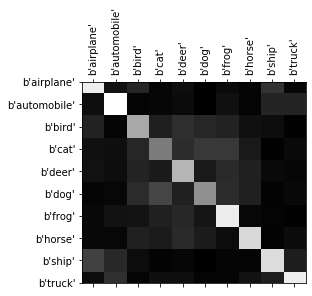

In [83]:
# # take the mean of predicted labels from the different classifier at each index
# ensemble_label = np.mean(prediction_array, axis = 0,dtype=np.int8) # np.int8 so mean is a whole number
print(np.asarray(prediction_ensemble))

# majority voting
ensemble_label = test_labels.copy()
for i in range(10000):
    votes = {} # hash table
    for j in range(6):
        if prediction_ensemble[j][i] in votes: # check if key is in hash table
            votes[prediction_ensemble[j][i]] += 1 # Increment counter
        else:
            votes[prediction_ensemble[j][i]] = 1 # create counter for this label
    #print(votes)
    ensemble_label[i] = max(votes, key=votes.get)    
        
    
print("Ensemble labels: " + str(ensemble_label))        
    
score = 100*accuracy_score(ensemble_label, testbatch_raw[b'labels'])
print("Accuracy of ensemble classifier: {0}%".format(score))

# Confusion matrix
# Create the confusion matrix using the function:
conf = confusion_matrix(testbatch_raw[b'labels'], ensemble_label ) # (answers, predictions)

plt.matshow(conf_hog_linear, cmap='gray') 
plt.xticks(np.arange(10),categ[b'label_names'], rotation = 90)
plt.yticks(np.arange(10),categ[b'label_names'])
plt.show()

Ensemble methods predict the class label by combining different training models on the same test data. Assuming that the majority of the classifier predicted the class label correctly, it is expected to be better than the best individual classifier. 

In my case, the ensemble classifier is a little bit less accurate than the best individual classifier ( 54.16% vs 57.17%). In my implementation of the voting algorithm, I populate a hash table with the labels as keys and the number of occurence as values at each index, then I take the key with the max number of occurence and put it in the ensemble_label array at the same index. In case of a tie, the max() function returns the first element it sees.In addition, I debbuged by printing some index and sometimes, the majority voting is not always working correctly, i.e. it assigns a label different than the majority.